In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
from scipy.special import gamma

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
alpha = 1.8


# Backend tensorflow.compat.v1
def fpde(x, y, int_mat):
    """du/dt + (D_{0+}^alpha + D_{1-}^alpha) u(x) = f(x)"""
    if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
        int_mat = tf.SparseTensor(*int_mat)
        lhs = -tf.sparse_tensor_dense_matmul(int_mat, y)
    else:
        lhs = -tf.matmul(int_mat, y)
    dy_t = tf.gradients(y, x)[0][:, 1:2]
    x, t = x[:, :-1], x[:, -1:]
    rhs = -dy_t - tf.exp(-t) * (
        x ** 3 * (1 - x) ** 3
        + gamma(4) / gamma(4 - alpha) * (x ** (3 - alpha) + (1 - x) ** (3 - alpha))
        - 3 * gamma(5) / gamma(5 - alpha) * (x ** (4 - alpha) + (1 - x) ** (4 - alpha))
        + 3 * gamma(6) / gamma(6 - alpha) * (x ** (5 - alpha) + (1 - x) ** (5 - alpha))
        - gamma(7) / gamma(7 - alpha) * (x ** (6 - alpha) + (1 - x) ** (6 - alpha))
    )
    return lhs - rhs[: tf.size(lhs)]

In [3]:
def func(x):
    x, t = x[:, :-1], x[:, -1:]
    return np.exp(-t) * x ** 3 * (1 - x) ** 3


geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

# Static auxiliary points
data = dde.data.TimeFPDE(
    geomtime,
    fpde,
    alpha,
    [bc, ic],
    [52],
    meshtype="static",
    num_domain=400,
    solution=func,
)

# Dynamic auxiliary points
'''data = dde.data.TimeFPDE(
     geomtime,
     fpde,
     alpha,
     [bc, ic],
     [100],
     num_domain=20,
     num_boundary=1,
     num_initial=1,
     solution=func,
     num_test=50,
 )'''

'data = dde.data.TimeFPDE(\n     geomtime,\n     fpde,\n     alpha,\n     [bc, ic],\n     [100],\n     num_domain=20,\n     num_boundary=1,\n     num_initial=1,\n     solution=func,\n     num_test=50,\n )'

Compiling model...
'compile' took 0.000309 s

Training model...



c:\Users\Marco\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss                        Test loss                         Test metric
0         [5.74e+00, 0.00e+00, 5.14e-19]    [5.74e+00, 0.00e+00, 0.00e+00]    []  
1000      [5.24e-03, 0.00e+00, 5.14e-19]    [5.24e-03, 0.00e+00, 0.00e+00]    []  
2000      [2.60e-03, 0.00e+00, 5.14e-19]    [2.60e-03, 0.00e+00, 0.00e+00]    []  
3000      [1.70e-03, 0.00e+00, 5.14e-19]    [1.70e-03, 0.00e+00, 0.00e+00]    []  
4000      [1.32e-03, 0.00e+00, 5.14e-19]    [1.32e-03, 0.00e+00, 0.00e+00]    []  
5000      [1.12e-03, 0.00e+00, 5.14e-19]    [1.12e-03, 0.00e+00, 0.00e+00]    []  
6000      [9.68e-04, 0.00e+00, 5.14e-19]    [9.68e-04, 0.00e+00, 0.00e+00]    []  
7000      [8.33e-04, 0.00e+00, 5.14e-19]    [8.33e-04, 0.00e+00, 0.00e+00]    []  
8000      [7.24e-04, 0.00e+00, 5.14e-19]    [7.24e-04, 0.00e+00, 0.00e+00]    []  
9000      [6.49e-04, 0.00e+00, 5.14e-19]    [6.49e-04, 0.00e+00, 0.00e+00]    []  
10000     [6.06e-04, 0.00e+00, 5.14e-19]    [6.06e-04, 0.00e+00, 0.00e+00]    []

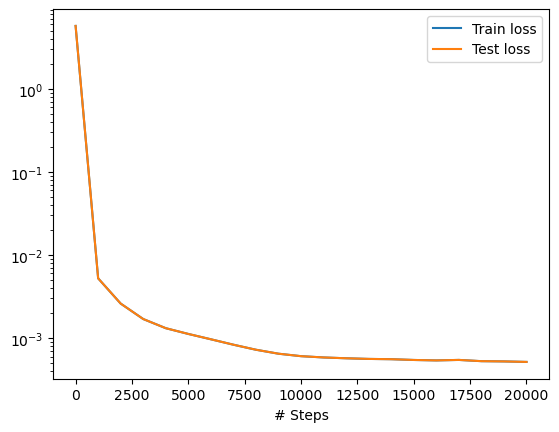

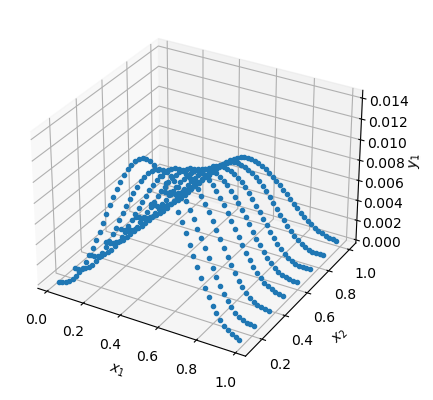

In [5]:
#net = dde.nn.FNN([2] + [100] + [1], "tanh", "Glorot normal")

M = 50
layer_size = [1] + [M]  +  [1]

activation = ["random_tanh", 'linear']

initializer = "Glorot uniform"
R = 4
net = dde.nn.random_FNN(layer_size, activation, initializer, Rm=R, b=R/10)
#net = dde.nn.FNN(layer_size, activation, initializer)

net.apply_output_transform(
    lambda x, y: x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * y
    + x[:, 0:1] ** 3 * (1 - x[:, 0:1]) ** 3
)


model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
print(losshistory.loss_test[-1])
model.compile("L-BFGS", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

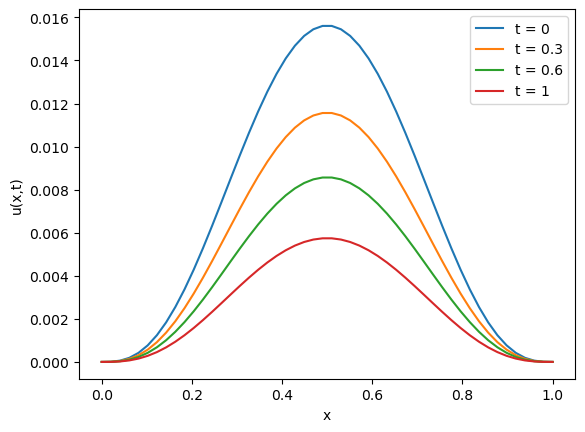

C:\Users\Marco\AppData\Local\Temp\ipykernel_15192\454080017.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0, 'u(x,t)')

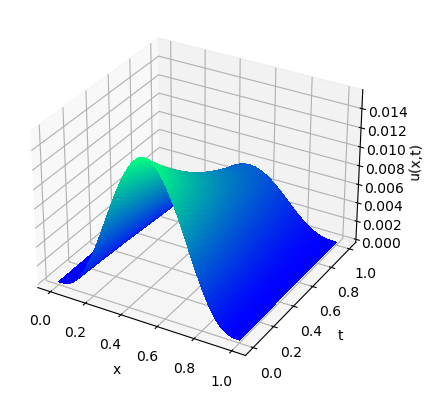

In [71]:
import pylab
from matplotlib import cm

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X,Y = pylab.meshgrid(x,y)

def p(x,t):
    return np.exp(-t)*(x**3 * (1-x)**3)
Z = p(X,Y)

xx = np.linspace(0,1)
for t in [0, 0.3, 0.6, 1]:
    plt.plot(xx, p(xx, t),label = 't = ' + str(t))
plt.legend()
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.winter,linewidth=0, antialiased=False)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')